<a href="https://colab.research.google.com/github/TarunvelVS/Forecasting_Model/blob/main/Stock_Price_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'yahoo-finance-dataset-2018-2023:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3242270%2F5640619%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240612%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240612T031544Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7e5bede431af2b684c9807117755d78771fd1b9af04dbc2865b87a624be8102c6a87c6d600c0a746f7d59690af40f21d660d8bc16b0ddea0d66e68b8eb433562375abef69f9256adf178e7f1782fbb0ecd5fabce7aa45833e35855e8bca90d1212147f8d8a91b71606c5837f24b6870ca135d3ab5543e61afa4a625cda89450e34eeeb0def62523c660eed87ecbe864110475b4500bc8ffb87c8734fd0ff5d29ca35fabcacd3f6f7cb88d78ed1b34f35dacc304b746cdea87750ebf821ab83642e5830ab7b53e6b187e9d0dbc2d034d02b70db541d36f8c21154d1504fc1fe46f613cd73bf409a6863818af4a489ea1315365f8c77fc2ae128b96394d7ff0b10'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 79394 bytes downloaded
Downloaded and uncompressed: yahoo-finance-dataset-2018-2023
Data source import complete.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yahoo-finance-dataset-2018-2023/yahoo_data.xlsx


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
data = pd.read_excel("/kaggle/input/yahoo-finance-dataset-2018-2023/yahoo_data.xlsx")

In [7]:
data.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,"Apr 28, 2023",33797.43,34104.56,33728.40,34098.16,34098.16,354310000
1,"Apr 27, 2023",33381.66,33859.75,33374.65,33826.16,33826.16,343240000
2,"Apr 26, 2023",33596.34,33645.83,33235.85,33301.87,33301.87,321170000
3,"Apr 25, 2023",33828.34,33875.49,33525.39,33530.83,33530.83,297880000
4,"Apr 24, 2023",33805.04,33891.15,33726.09,33875.40,33875.40,252020000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1258 non-null   object 
 1   Open         1258 non-null   float64
 2   High         1258 non-null   float64
 3   Low          1258 non-null   float64
 4   Close*       1258 non-null   float64
 5   Adj Close**  1258 non-null   float64
 6   Volume       1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [9]:
data["Date"] = pd.to_datetime(data["Date"])

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1258 non-null   datetime64[ns]
 1   Open         1258 non-null   float64       
 2   High         1258 non-null   float64       
 3   Low          1258 non-null   float64       
 4   Close*       1258 non-null   float64       
 5   Adj Close**  1258 non-null   float64       
 6   Volume       1258 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 68.9 KB


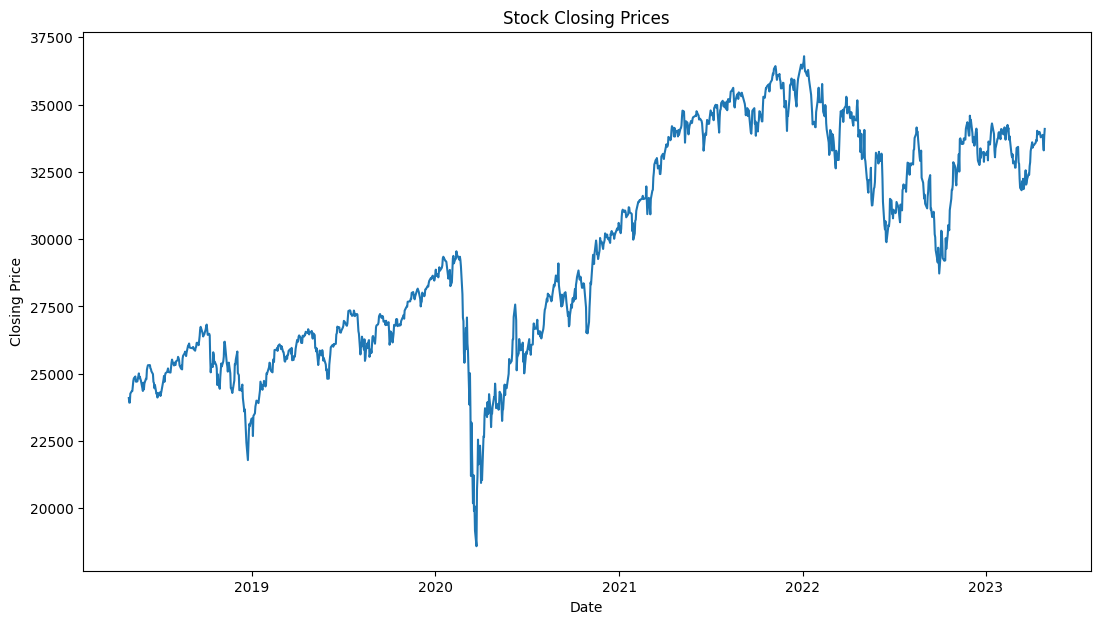

In [13]:
#Plotting the closing Prices
plt.figure(figsize=(13,7))
plt.plot(data["Date"], data["Close*"])
plt.title("Stock Closing Prices")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

**Augmented Dickey-Fuller Test**

The Augmented Dickey-Fuller (ADF) test is used to determine if a time series is stationary. Stationarity means that the statistical properties of the series (mean, variance) do not change over time. A stationary time series is essential for many time series models, including ARIMA, to provide reliable forecasts.

In [14]:
from statsmodels.tsa.stattools import adfuller

In [16]:
# Check for stationarity
result = adfuller(data['Close*'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.4204412523508354
p-value: 0.5724380460701357


 **Key Points:**

• **ADF Statistic:**

The ADF statistic is a negative number. The more negative the value, the stronger the evidence against the null hypothesis (which states that the series is non-stationary).

• **p-value:**

The p-value is the probability that the series is non-stationary. A lower p-value indicates stronger evidence against the null hypothesis.
Common significance levels for the p-value are 0.01, 0.05, and 0.10.

**Interpretation:**
1. Since the p-value (0.5724) is much higher than any common significance level (0.01, 0.05, 0.10), we fail to reject the null hypothesis. This suggests that the series is *non-stationary*.
2. The ADF statistic (-1.4204) is not very negative, which also supports the conclusion that the series is *non-stationary*.

To make the series stationary, you can apply differencing. Differencing involves subtracting the previous observation from the current observation. This process can be repeated (second differencing, third differencing, etc.) until the series becomes stationary.

In [19]:
# Perform first-order differencing
data['Close_diff'] = data['Close*'].diff().dropna()

In [21]:
# Re-run the ADF test on the differenced series
result_diff = adfuller(data['Close_diff'].dropna())
print(f'ADF Statistic (Differenced): {result_diff[0]}')
print(f'p-value (Differenced): {result_diff[1]}')

ADF Statistic (Differenced): -10.821396189588262
p-value (Differenced): 1.8017893361808337e-19


**Interpretation of Differenced ADF Test Results**

**Key Points:**

**ADF Statistic:**

The ADF statistic is highly negative (-10.8214). A more negative value indicates stronger evidence against the null hypothesis (non-stationarity).

**p-value:**

The p-value (1.8017893361808337e-19) is extremely low (practically zero), much lower than any common significance level (0.01, 0.05, 0.10).

**Conclusion:**

Since the p-value is significantly less than 0.05, we reject the null hypothesis that the series is non-stationary. This suggests that the differenced series is stationary.

The highly negative ADF statistic further supports the conclusion that the series is stationary after differencing.

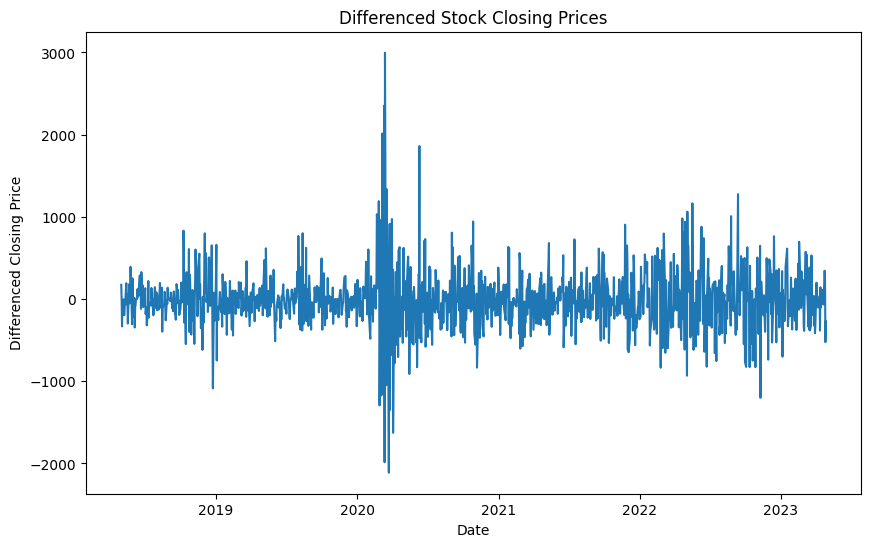

In [22]:
# Plot the differenced closing prices
plt.figure(figsize=(10, 6))
plt.plot(data["Date"], data['Close_diff'])
plt.title('Differenced Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Closing Price')
plt.show()

In [24]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [27]:
# Split the data into training and testing sets
train_size = int(len(data['Close_diff'].dropna()) * 0.8)
train, test = data['Close_diff'].dropna().iloc[:train_size], data['Close_diff'].dropna().iloc[train_size:]

In [28]:
# Fit the ARIMA model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [29]:
# Make predictions
predictions = model_fit.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [30]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 235.31134944569132
MAE: 166.28713935796807


**Interpretation of RMSE and MAE**

**RMSE: 235.31**

RMSE measures the square root of the average squared differences between the predicted and actual values.

A lower RMSE indicates a better fit. The units of RMSE are the same as the original values (in this case, the differenced closing prices).

**MAE: 166.29**

MAE measures the average absolute differences between the predicted and actual values.

A lower MAE also indicates a better fit. The units of MAE are the same as the original values.

In [32]:
import itertools
from statsmodels.tsa.arima.model import ARIMA

In [33]:
p = d = q = range(0, 3)

In [34]:
pdq = list(itertools.product(p, d, q))

In [35]:
# Generate all different combinations of seasonal p, d and q triplets (0,0,0)
seasonal_pdq = [(x[0], x[1], x[2], 0) for x in pdq]

In [36]:
# AIC comparison
aic_values = []
params = []

In [37]:
for param in pdq:
    try:
        mod = ARIMA(train, order=param)
        results = mod.fit()
        aic_values.append(results.aic)
        params.append(param)
    except:
        continue

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dat

In [38]:
# Find the parameters with minimal AIC value
min_aic_index = aic_values.index(min(aic_values))
best_params = params[min_aic_index]
print(f'Best ARIMA parameters: {best_params}')

Best ARIMA parameters: (2, 0, 2)


In [39]:
# Fit the best ARIMA model
model = ARIMA(train, order=best_params)
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [40]:
# Make predictions
predictions = model_fit.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [41]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 236.65439749647754
MAE: 169.01917052350035
